Prediction model

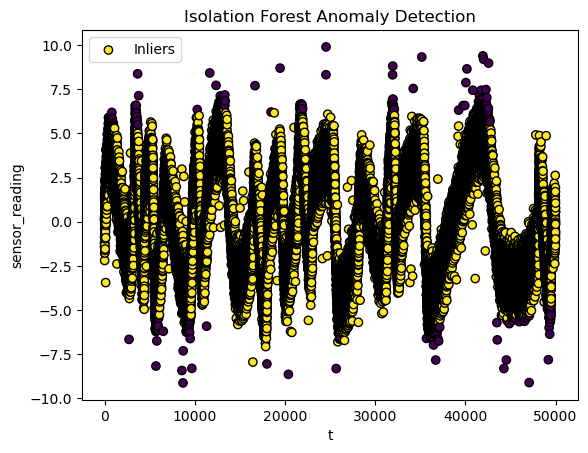

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Load data from CSV file
df = pd.read_csv('xad07.csv')

# Extract features from the DataFrame
X = df[['t', 'sensor_reading']].values

# Train the Isolation Forest model
clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
clf.fit(X)

# Predict the anomalies
y_pred = clf.predict(X)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', edgecolor='k', label='Inliers')
plt.xlabel('t')
plt.ylabel('sensor_reading')
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.show()

In [2]:
# Add the predicted labels as a new column to the DataFrame
df['anomaly'] = y_pred

# Filter the anomalous entries
anomalous_entries = df[df['anomaly'] == -1]

# Sort the anomalous entries by 'sensor_reading' in descending order
top_anomalous_entries = anomalous_entries.sort_values(by='sensor_reading', ascending=False).head(100)

# Export the top 100 anomalous entries to a text file
top_anomalous_entries.to_csv('output.txt', sep='\t', index=False, columns=['t'], header=None)

In [3]:
# Get the indices of anomalous entries
anomalous_indices = np.where(y_pred == -1)[0]

# Print the indices of anomalous entries
if len(anomalous_indices) > 0:
    print("Indices of anomalous entries:")
    print(anomalous_indices)
else:
    print("No anomalous entries found.")

Indices of anomalous entries:
[  291   368   381   387   425   429   431   439   442   444   461   467
   474   475   481   493   494   504   507   516   517   521   526   529
   531   535   538   543   553   554   574   577   584   585   588   592
   596   597   598   600   601   611   624   625   629   631   632   638
   639   642   643   650   657   658   662   668   676   682   684   688
   693   705   713   727   739   741   746   768   803   805   829   832
   852   857   858   867   884   899   913   914   948   952   960   966
   968   970   977   990  1002  2711  3372  3373  3385  3388  3391  3392
  3408  3412  3413  3429  3443  3445  3446  3448  3451  3458  3464  3467
  3473  3478  3483  3488  3491  3502  3503  3505  3511  3519  3520  3522
  3527  3528  3546  3560  3565  3566  3571  3587  3606  3610  3617  3628
  3667  3679  3776  5601  5609  5617  5622  5624  5625  5626  5629  5634
  5645  5648  5653  5654  5663  5670  5679  5686  5689  5694  5697  5705
  5713  5736  5754  5

Via trained AI One Class SVM

In [4]:
train_sz = int(len(df)*0.5)
train_dt, test_dt = df.iloc[:train_sz], df.iloc[train_sz:]

clf = OneClassSVM(nu=0.01,kernel='rbf',gamma=0.1)
clf.fit(train_dt[['sensor_reading']])

y_pred_train = clf.predict(train_dt[['sensor_reading']])
y_pred_test = clf.predict(test_dt[['sensor_reading']])

n_err_train = y_pred_train[y_pred_train == -1].size
n_err_test = y_pred_test[y_pred_test == -1].size
print("Number of errors on trianing set:", n_err_train)
print("Number of errors on test set", n_err_test)

Number of errors on trianing set: 485
Number of errors on test set 428


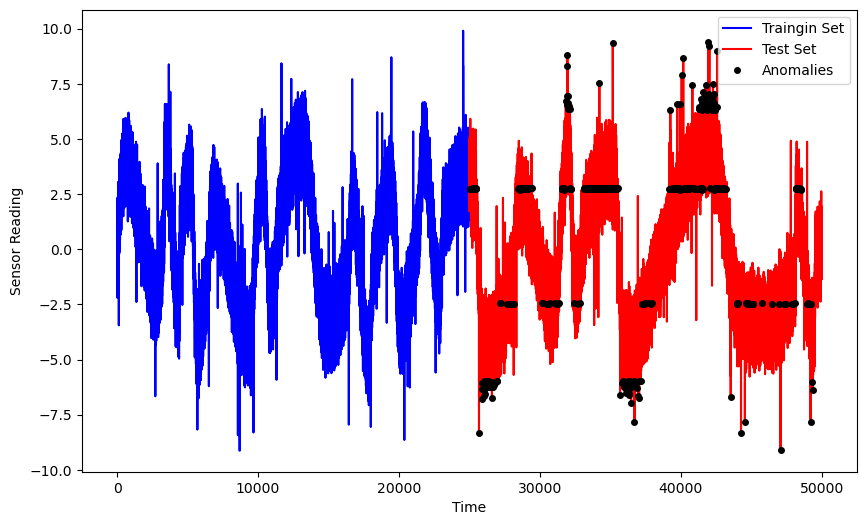

In [5]:
plt.figure(figsize=(10,6))
plt.plot(train_dt['t'],train_dt['sensor_reading'],'b',markersize=2)
plt.plot(test_dt['t'],test_dt['sensor_reading'],'r',markersize=2)
plt.plot(test_dt['t'][y_pred_test==-1],test_dt['sensor_reading'][y_pred_test==-1],'ko',markersize=4)
plt.xlabel('Time')
plt.ylabel('Sensor Reading')
plt.legend(['Traingin Set','Test Set','Anomalies'])
plt.show()

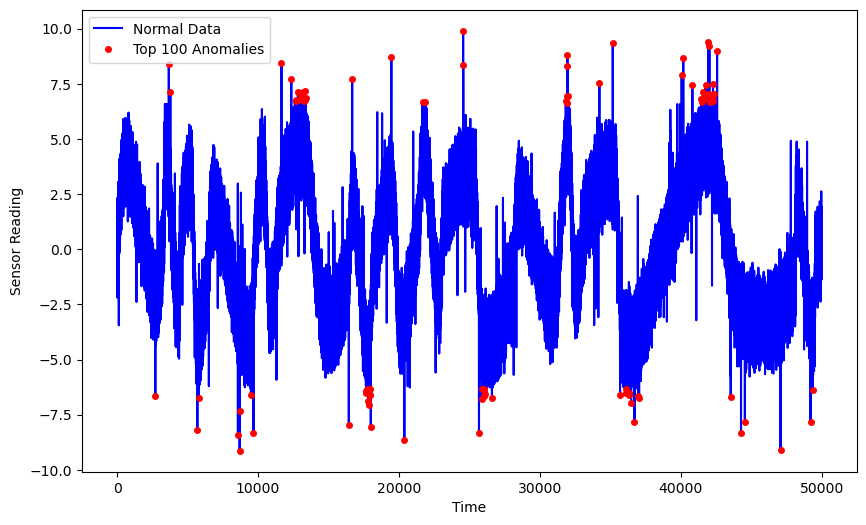

In [6]:
y_pred = clf.predict(df[['sensor_reading']])
df['anomaly_score'] = clf.decision_function(df[['sensor_reading']]) 

result = df.sort_values(by=['anomaly_score'])[:100]

plt.figure(figsize=(10,6))
plt.plot(df['t'],df['sensor_reading'],'b',markersize=2)
plt.plot(result['t'],result['sensor_reading'],'ro',markersize=4)
plt.xlabel('Time')
plt.ylabel('Sensor Reading')
plt.legend(['Normal Data','Top 100 Anomalies'])
plt.show()

In [7]:
# Export the top 100 anomalous entries to a text file
result.to_csv('output2.txt', sep='\t', index=False, columns=['t'], header=None)

In [8]:
import string
import math
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def calculate_text_similarity(file1, file2):
    """
    Calculates the similarity between the content of two text files in percentage using the cosine similarity measure.

    Args:
        file1 (str): File path of the first text file.
        file2 (str): File path of the second text file.

    Returns:
        float: Similarity between the content of two text files in percentage.
    """

    # Read the content of the first file
    with open(file1, 'r') as f:
        file1_content = f.read()

    # Read the content of the second file
    with open(file2, 'r') as f:
        file2_content = f.read()

    # Preprocess the text by removing punctuation and converting to lowercase
    def preprocess(text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text

    file1_content = preprocess(file1_content)
    file2_content = preprocess(file2_content)

    # Tokenize the text into words
    file1_words = file1_content.split()
    file2_words = file2_content.split()

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    file1_words = [word for word in file1_words if word not in stop_words]
    file2_words = [word for word in file2_words if word not in stop_words]

    # Create a Counter for each file's words
    file1_word_counter = Counter(file1_words)
    file2_word_counter = Counter(file2_words)

    # Calculate dot product and magnitude for cosine similarity
    dot_product = sum(file1_word_counter[word] * file2_word_counter[word] for word in file1_word_counter if word in file2_word_counter)
    file1_magnitude = math.sqrt(sum(file1_word_counter[word] ** 2 for word in file1_word_counter))
    file2_magnitude = math.sqrt(sum(file2_word_counter[word] ** 2 for word in file2_word_counter))

    # Calculate cosine similarity
    similarity = dot_product / (file1_magnitude * file2_magnitude)

    # Convert cosine similarity to percentage
    similarity_percentage = similarity * 100

    return similarity_percentage

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMINSTRATOR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [10]:
calculate_text_similarity("output.txt","output2.txt")

51.0